# Notebook 2 – Clustering of Conington Coins
### Goal: 
- explore numeric patterns using K‑means (exploratory only)
- explore distribution
- try simple clustering and classification


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score


In [92]:
coins = pd.read_csv("../data/Coins_clean.csv")
coins.head()

,PERIOD,CONTEXT,MATERIAL,COIN_TYPE,COIN_REGIME,RULER,COIN_EDATE,COIN_LDATE,DENOMINATION,DIAMETER,MINT,COIN_CONDITION,mid_date,date_span
0,99.0,320002,COPPER ALLOY,NaN,NaN,NaN,700.0,900.0,NaN,NaN,NaN,NaN,800.0,200.0
1,99.0,320002,COPPER ALLOY,COPY,R,CONSTANTIUS II,330.0,335.0,NaN,16.0,TRIER,NaN,332.5,5.0
2,99.0,320002,SILVER,COIN,E,NaN,1066.0,1485.0,NaN,9.0,NaN,CUTQ,1275.5,419.0
3,99.0,320002,COPPER ALLOY,COIN,R,VALENTINIAN I,364.0,365.0,NUMMUS,20.0,ARLES,NaN,364.5,1.0
4,99.0,320002,COPPER ALLOY,JETTON,N,NaN,1550.0,1635.0,NaN,24.0,NaN,NaN,1592.5,85.0


Modeling Question: Can basic features group coins into meaningful clusters?” (K‑Means on numeric columns like date, diameter, weight)

Select features + drop missing

In [93]:
features = ["mid_date", "date_span", "DIAMETER"]
df = coins[features].dropna()

print("Rows for clustering:", len(df))
df.describe()



Rows for clustering: 43


,mid_date,date_span,DIAMETER
count,43.000000,43.000000,43.000000
mean,584.081395,60.441860,17.860465
std,526.470660,106.257168,5.222804
min,-5.000000,0.000000,8.000000
25%,320.750000,2.000000,14.500000
50%,338.500000,10.000000,17.000000
75%,536.750000,74.000000,20.000000
max,1750.000000,500.000000,32.000000


### Scale Features

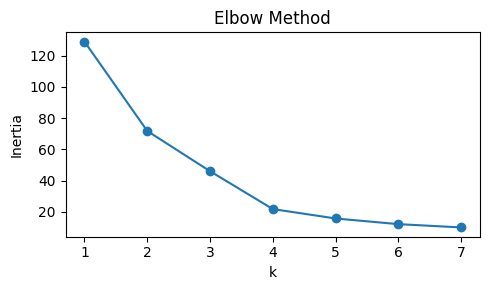

In [94]:
# Scale features so each has mean=0 and std=1 (K-means is distance-based)
scaler = StandardScaler()
X = scaler.fit_transform(df)

# Choose K using the elbow method
inertia = []
k_range = range(1, 8)

for k in k_range:
    # Fit K-means for each k and store the inertia (within-cluster sum of squares)
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

# Plot inertia vs k to find the "elbow" (within cluster sum pf squares) which shows how much the fit improves with increasing k
plt.figure(figsize=(5,3))
plt.plot(k_range, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()


Fit K

In [95]:
k = 4  #chosen number of clusters based on elbow plot
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) 
labels = kmeans.fit_predict(X)

df_clustered = df.copy()
df_clustered["cluster"] = labels
df_clustered["cluster"].value_counts()


cluster
0    29
1     7
3     5
2     2
Name: count, dtype: int64

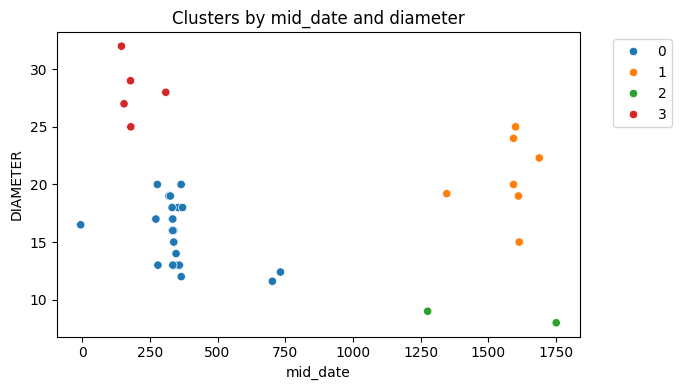

In [96]:
#visualize clusters
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df_clustered,
    x="mid_date",
    y="DIAMETER",
    hue="cluster",
    palette="tab10"
)
plt.title("Clusters by mid_date and diameter")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [97]:
## interpret cluster

df_clustered.groupby("cluster").mean()
# df_clustered.groupby("cluster").std()

,mid_date,date_span,DIAMETER
cluster,,,
0,347.551724,22.896552,16.051724
1,1577.500000,111.000000,20.642857
2,1512.750000,459.500000,8.500000
3,193.700000,47.800000,28.200000


In [98]:

# See how clusters align with known regimes/materials
pd.crosstab(coins.loc[df_clustered.index, "COIN_REGIME"], df_clustered["cluster"])
#pd.crosstab(coins.loc[df_clustered.index, "MATERIAL"], df_clustered["cluster"])

cluster,0,1,2,3
COIN_REGIME,,,,
AS,2,0,0,0
E,0,3,1,0
IA,1,0,0,0
N,0,3,0,0
R,26,0,0,5


In [99]:
coins_clustered = coins.join(df_clustered["cluster"])

coins_clustered.head()

,PERIOD,CONTEXT,MATERIAL,COIN_TYPE,COIN_REGIME,RULER,COIN_EDATE,COIN_LDATE,DENOMINATION,DIAMETER,MINT,COIN_CONDITION,mid_date,date_span,cluster
0,99.0,320002,COPPER ALLOY,NaN,NaN,NaN,700.0,900.0,NaN,NaN,NaN,NaN,800.0,200.0,NaN
1,99.0,320002,COPPER ALLOY,COPY,R,CONSTANTIUS II,330.0,335.0,NaN,16.0,TRIER,NaN,332.5,5.0,0.0
2,99.0,320002,SILVER,COIN,E,NaN,1066.0,1485.0,NaN,9.0,NaN,CUTQ,1275.5,419.0,2.0
3,99.0,320002,COPPER ALLOY,COIN,R,VALENTINIAN I,364.0,365.0,NUMMUS,20.0,ARLES,NaN,364.5,1.0,0.0
4,99.0,320002,COPPER ALLOY,JETTON,N,NaN,1550.0,1635.0,NaN,24.0,NaN,NaN,1592.5,85.0,1.0


### Interpretation 

**patterns in time, uncertainty, and size**
- **Cluster 0:** Early coins with **tight dating windows** and **small diameters** → well‑dated early issues.
- **Cluster 3:** Early coins with **moderate dating windows** and **large diameters** → early issues, but physically larger and slightly less precise.
- **Cluster 1:** Later coins with **moderate date spans** and **medium diameters** → later issues with typical uncertainty.
- **Cluster 2:** Later coins with **very wide date spans** and **very small diameters** → later issues that are **poorly constrained** in time and physically small.

**Key insight**
The clusters are driven by three axes:  
1) **When** the coin is dated (mid_date),  
2) **How precisely** it is dated (date_span), and  
3) **Physical size** (diameter).  


### Q: Did K-Means clustering added new information beyond my EDA?Can I see supattern in roman coins?

## Limitations
- Small sample size after dropping missing values.
- Only a few numeric features available.
- K‑means assumes spherical clusters and is sensitive to scaling.
- Results are exploratory, not definitive.

### Q: focus on roman coins and see if there are sub patterns ?

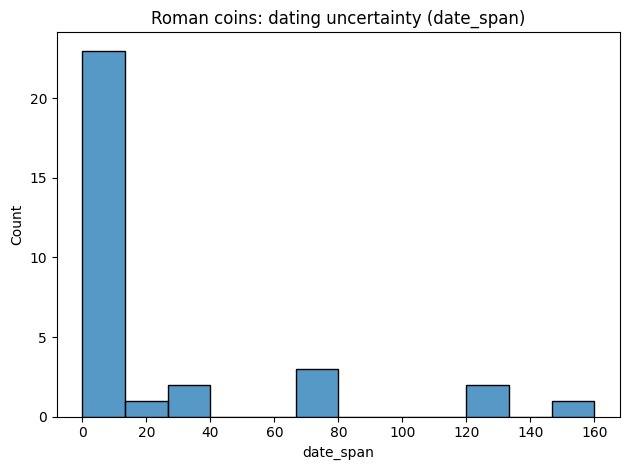

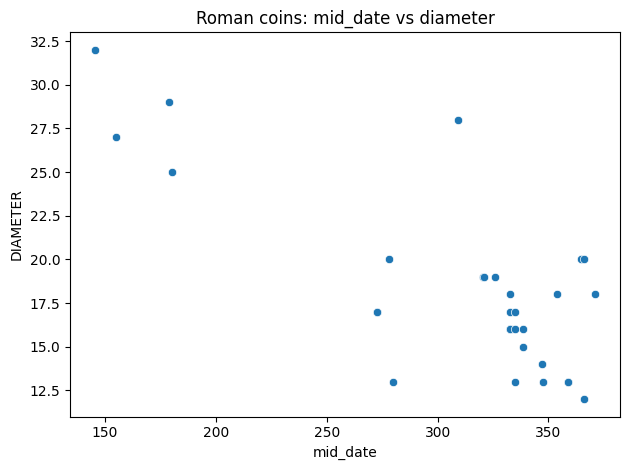

In [100]:
roman = coins[coins["COIN_REGIME"] == "R"]

# Dating precision for Roman coins
sns.histplot(data=roman, x="date_span", bins=12)
plt.title("Roman coins: dating uncertainty (date_span)")
plt.tight_layout()
plt.show()

# Dating vs size for Roman coins
sns.scatterplot(data=roman, x="mid_date", y="DIAMETER")
plt.title("Roman coins: mid_date vs diameter")
plt.tight_layout()
plt.show()


## Ideas for Next Steps: 
-try a roman classification (exploratory) with sub-labels (problem is very sparse data in coin-type, denomination, ruler...)
- binary classification roman vs non roman (mid date, date span, diameter)

In [101]:
# roman vs non roman with cross-validation setup

# How many labeled regimes?
coins["COIN_REGIME"].value_counts(dropna=False)

# Binary target: Roman vs non‑Roman
coins["is_roman"] = coins["COIN_REGIME"] == "R"

# numeric features
features = ["mid_date", "date_span", "DIAMETER"]
df_cls = coins.dropna(subset=features + ["COIN_REGIME"])

X = df_cls[features]
y = df_cls["is_roman"]

print("Rows:", len(df_cls))
print("Class balance:\n", y.value_counts())


Rows: 41
Class balance:
 is_roman
True     31
False    10
Name: count, dtype: int64


#### Roman vs non‑Roman classification (exploratory)
I tested a simple logistic regression using `mid_date`, `date_span`, and `DIAMETER` to classify Roman vs non‑Roman coins.  
Because the dataset is small and imbalanced, results are **exploratory** and should not be treated as reliable predictive performance.  
The goal is to see whether basic numeric features contain signal for Roman vs non‑Roman coins.

In [106]:
# model and cross validation
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#y_pred = cross_val_predict(pipe, X, y, cv=cv)
y_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:,1]
threshold = 0.7
y_pred = (y_proba >= threshold)

print("Confusion matrix:\n", confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, digits=3))


Confusion matrix:
 [[ 7  3]
 [ 0 31]]
              precision    recall  f1-score   support

       False      1.000     0.700     0.824        10
        True      0.912     1.000     0.954        31

    accuracy                          0.927        41
   macro avg      0.956     0.850     0.889        41
weighted avg      0.933     0.927     0.922        41



### Interpretation: 
rows= actual, columns = predicted
- 7 non-roman correctly predicted (true negatives)
- 3 non roman predicted as roman (false positives)
- 0 roman predicted as non-roman (false negatives)
- 31 roman correctly predicted (true positives) 

&rarr; recall for roman 1.000 
&rarr; recall for roman 0.7 (30% of non-roman are missed)

This concludes to an accuraca of 0.927 but with the imbalance of roman coins making 31 of 41 coins it is not really aussagekräftig



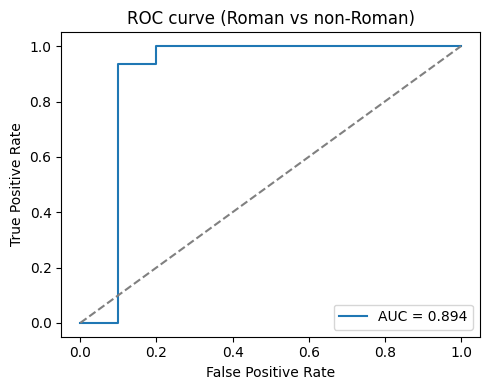

In [ ]:
y_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:,1]
fpr, tpr, _ = roc_curve(y, y_proba)
auc = roc_auc_score(y, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Roman vs non‑Roman)")
plt.legend()
plt.tight_layout()
plt.show()



looks good but the caveat is the small dataset so I will see in more detail with precision/recall

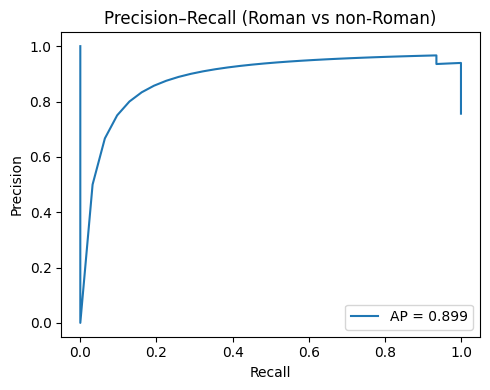

In [104]:
y_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:,1]
precision, recall, _ = precision_recall_curve(y, y_proba)
ap = average_precision_score(y, y_proba)

plt.figure(figsize=(5,4))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (Roman vs non‑Roman)")
plt.legend()
plt.tight_layout()
plt.show()


### Precision–Recall interpretation
The curve shows how precision drops when I try to catch all Roman coins.  
At very strict thresholds, the model predicts almost no positives, so the curve jumps a lot (small dataset effect).  
At the far right (recall ≈ 1), we label almost everything as Roman, so precision drops because of many false positives.  
Overall AP ≈ 0.899 is strong, but results are still exploratory due to small sample size.


### Classification Conclusion + Limitations

A simple logistic regression using `mid_date`, `date_span`, and `DIAMETER` can separate Roman from non‑Roman coins reasonably well in cross‑validation.  
ROC‑AUC and Precision–Recall suggest meaningful signal, but performance is unstable due to the very small, imbalanced dataset.

**Limitations**
- Only ~41 labeled rows are usable.
- Class imbalance (many more Roman than non‑Roman).
- Cross‑validation results may vary with different splits.
- Model is exploratory and not suitable for real predictive claims.


## 4. linear regression


In [107]:

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

# numeric features -> numeric target
features = ["mid_date", "date_span"]
target = "DIAMETER"

df_reg = coins.dropna(subset=features + [target])
X = df_reg[features]
y = df_reg[target]

model = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2")
rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error")

print("R2 (mean ± std):", round(r2_scores.mean(), 3), "±", round(r2_scores.std(), 3))
print("RMSE (mean ± std):", round(rmse_scores.mean(), 3), "±", round(rmse_scores.std(), 3))

# Fit once to inspect coefficients (exploratory)
model.fit(X, y)
print("Coefficients:", dict(zip(features, model.coef_)))
print("Intercept:", model.intercept_)

R2 (mean ± std): -0.238 ± 0.323
RMSE (mean ± std): 5.253 ± 0.935
Coefficients: {'mid_date': np.float64(0.0007401397968951778), 'date_span': np.float64(-0.012760198324609333)}
Intercept: 18.199413357598576


## 5. Decision tree

Confusion matrix:
 [[ 7  3]
 [ 0 31]]
              precision    recall  f1-score   support

       False      1.000     0.700     0.824        10
        True      0.912     1.000     0.954        31

    accuracy                          0.927        41
   macro avg      0.956     0.850     0.889        41
weighted avg      0.933     0.927     0.922        41



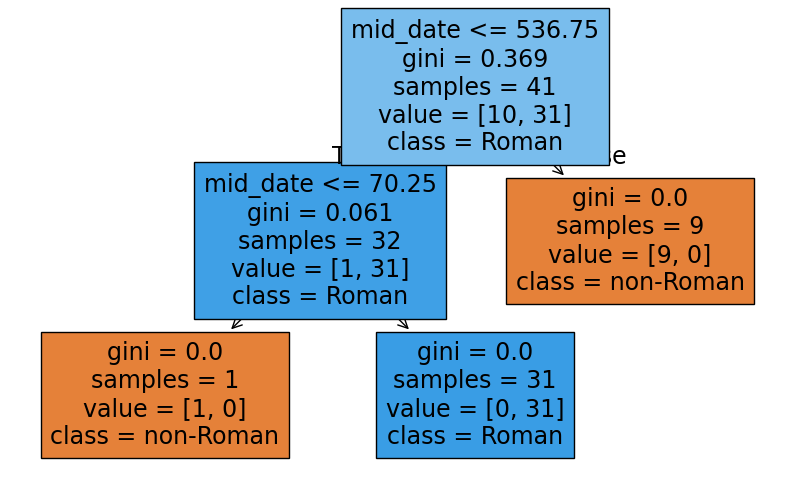

In [108]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# binary target
coins["is_roman"] = coins["COIN_REGIME"] == "R"

features = ["mid_date", "date_span", "DIAMETER"]
df_cls = coins.dropna(subset=features + ["COIN_REGIME"])

X = df_cls[features]
y = df_cls["is_roman"]

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(clf, X, y, cv=cv)

print("Confusion matrix:\n", confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, digits=3))

# Optional: fit once and visualize the tree (exploratory)
clf.fit(X, y)
plt.figure(figsize=(10,6))
plot_tree(clf, feature_names=features, class_names=["non‑Roman", "Roman"], filled=True)
plt.show()
